### Do primates with larger brains produce more energetic milk?

In [24]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import missingno as msno
import statsmodels.formula.api as smf
import matplotlib.pyplot as graph

graph.style.use('fivethirtyeight')

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv', sep=';')
df.columns = [col.replace('.', '_') for col in df.columns]
df['log_mass'] = np.log(df['mass'])

df.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc,log_mass
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.667829
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0.737164
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0.920283
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0.482426
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0.783902


/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


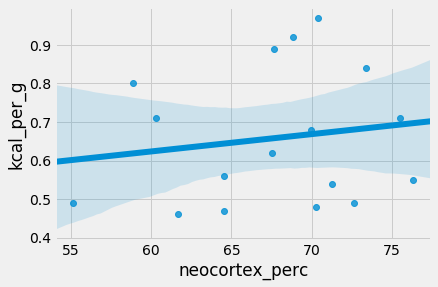

In [26]:
sns.regplot(df['neocortex_perc'], df['kcal_per_g'])
graph.show()

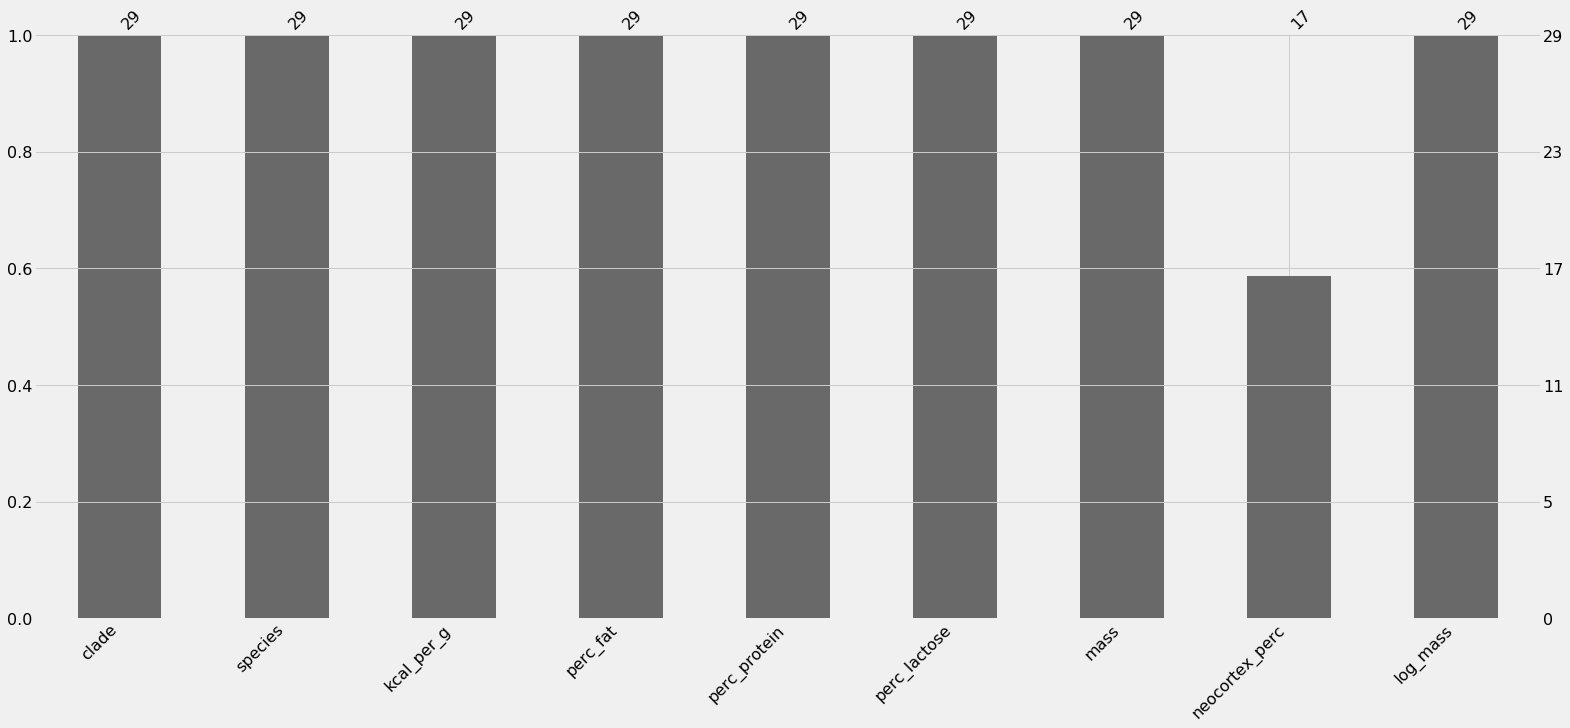

In [27]:
msno.bar(df)
graph.show()

In [28]:
df.dropna(inplace=True)
print(df.shape)

(17, 9)


In [29]:
model = smf.ols('kcal_per_g ~ neocortex_perc', data=df)
results = model.fit()

display(results.summary())

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             kcal_per_g   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.3715
Date:                Wed, 17 Oct 2018   Prob (F-statistic):              0.551
Time:                        10:18:24   Log-Likelihood:                 6.4371
No. Observations:                  17   AIC:                            -8.874
Df Residuals:                      15   BIC:                            -7.208
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3533      0.501      0.705      0.492      -0.715       1.421
neocortex_perc     0.0045      0.007      0.609      0.551      -0.011       0.020
==============================================================================
Omnibus:                        3.558   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                1.693
Skew:                           0.454   Prob(JB):                        0.429
Kurtosis:                       1.748   Cond. No.                         795.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_neocortex, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:10<00:00, 182.04draws/s]


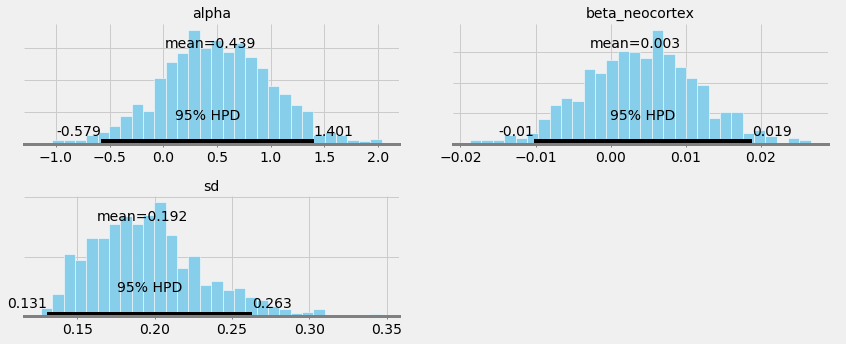

In [30]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta = pm.Normal('beta_neocortex', 0, 100)
    sd = pm.Uniform('sd', 0, 1)
    
    # Linear relationship
    mu = alpha + beta * df['neocortex_perc']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['kcal_per_g'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)
    graph.show()

It seems the percentage of neocortex in the brain does not have a relationship with the energy of milk produced when it is the only variable in the model. Let's add the mass of the organism and see how that changes but first let's model the mass by itself. 

In [31]:
model = smf.ols('kcal_per_g ~ log_mass', data=df)
results = model.fit()

display(results.summary())

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             kcal_per_g   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.153
Date:                Wed, 17 Oct 2018   Prob (F-statistic):              0.163
Time:                        10:18:38   Log-Likelihood:                 7.3691
No. Observations:                  17   AIC:                            -10.74
Df Residuals:                      15   BIC:                            -9.072
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7052      0.052     13.599      0.000       0.595       0.816
log_mass      -0.0317      0.022     -1.467      0.163      -0.078       0.014
==============================================================================
Omnibus:                        0.817   Durbin-Watson:                   1.150
Prob(Omnibus):                  0.664   Jarque-Bera (JB):                0.788
Skew:                           0.339   Prob(JB):                        0.674
Kurtosis:                       2.191   Cond. No.                         3.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It looks like mass alone also does not have a relationship with energy in milk. Now let's put both in the same model. 

In [32]:
model = smf.ols('kcal_per_g ~ neocortex_perc + log_mass', data=df)
results = model.fit()

display(results.summary())

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             kcal_per_g   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     7.948
Date:                Wed, 17 Oct 2018   Prob (F-statistic):            0.00494
Time:                        10:18:39   Log-Likelihood:                 12.678
No. Observations:                  17   AIC:                            -19.36
Df Residuals:                      14   BIC:                            -16.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0853      0.515     -2.106      0.054      -2.190       0.020
neocortex_perc     0.0279      0.008      3.485      0.004       0.011       0.045
log_mass          -0.0964      0.025     -3.895      0.002      -0.149      -0.043
==============================================================================
Omnibus:                        0.415   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.813   Jarque-Bera (JB):                0.265
Skew:                          -0.271   Prob(JB):                        0.876
Kurtosis:                       2.716   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_mass, beta_neocortex, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:14<00:00, 139.61draws/s]
The acceptance probability does not match the target. It is 0.9050140857468016, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


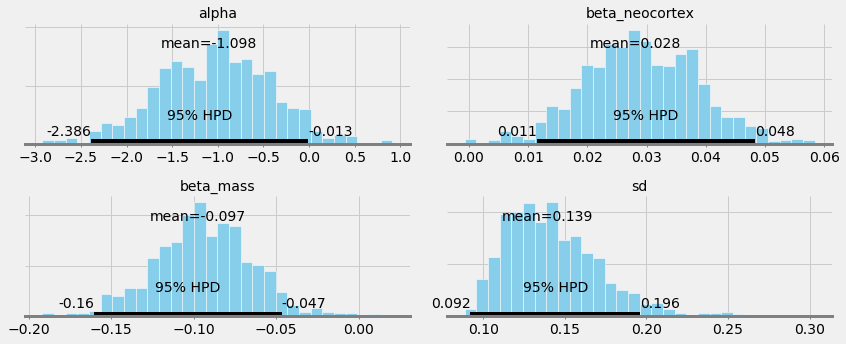

In [34]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta_neo = pm.Normal('beta_neocortex', 0, 100)
    beta_mass = pm.Normal('beta_mass', 0, 100)
    sd = pm.Uniform('sd', 0, 1)
    
    # Linear relationship
    mu = alpha + beta_neo * df['neocortex_perc'] + beta_mass * np.log(df['mass'])
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['kcal_per_g'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)
    graph.show()

Wow - having both covariates in the model makes both slopes significant and higher than when each was modeled individually. This tends to happen when both predictors are correlated with one another but each have the opposite correlation with the outcome thus cancelling each other out. 

Including both predictors in the model asks 'do species with a high neocortex percentage for their body mass have higher milk energy?' or 'do species with a higher mass for their neocortex percent have higher milk energy?'

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


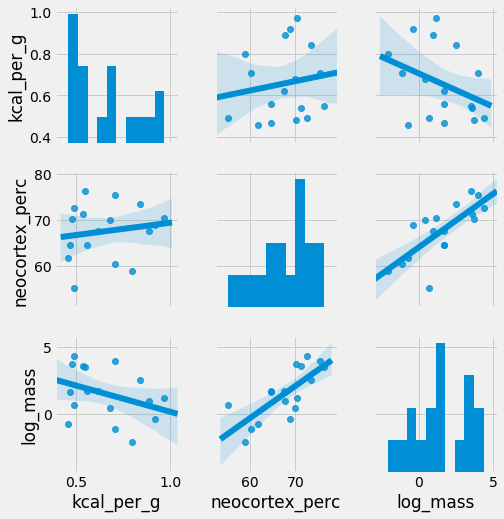

In [39]:
sns.pairplot(df[['kcal_per_g', 'neocortex_perc', 'log_mass']], kind='reg')
graph.show()